# Practica 1 Optimización para Grandes Volumenes de Datos - Paralelización
## Implementación paralelizada y evaluación de un algoritmo de ML supervisado

Esta entrega ha sido realizada por Adrián Contreras Castillo y Jaime González Delgado.

## Introducción

Para la realización de esta práctica se parte de la versión centralizada proporcionada por la asignatura. La versión centralizada dispone el entrenamiento de un algoritmo de ML sin paralelizar donde tampoco se incluye la regularización en la funció de coste ni tampoco en las derivadas necesarias para el cálculo del descenso de gradiente. Además la versión proporcionada tampoco hace uso de la vectorización de las operciones que ofrece la librería Numpy. El empleo de numpy arrays en vez de las listas de python suponen la introducción de operadores de vectores y matrices, así como, un aumento en la velocidad de ejecución. Lo que se busca con el desarrollo de esta práctica es implementar las fucionalidades anteriormente descritas de tal forma que se otenga un código que haga empleo de la paralelización que ofrece PySpark, con el fin de reducir los tiempos de ejecución, evaluando también la configuración de workers más optima.

El siguiente código cuenta con la implementación de la paralelización, además en aquellas funciones donde se puede hacer uso de los operadores de numpy han sido modificas con el fin de optimizar la velocidad de computo. También, la implementación de la función de coste, asi como el cálculo de las derivadas incluye la regularización.

In [ ]:
import findspark

findspark.init()

from pyspark import SparkContext
import numpy as np
import time
import random
import math
from operator import add

In [ ]:
sc = SparkContext("local[*]", "practica")

24/02/19 10:32:14 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/02/19 10:32:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/02/19 10:32:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Proceso de paralelización

In [ ]:
def readFile (filename):
    """Arguments:
    filename – name of the spam dataset file
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y)
    Y -- Train labels (0 if normal traffic, 1 if botnet)
    m rows: number of examples (m)
    Returns:
    An RDD containing the data of filename. Each example (row) of the file
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)"""
    rdd = sc.textFile(filename)
    column_data = rdd.map(lambda x: (np.array([float(elem) for elem in x.split(",")[:-1]]),
                                     int(x.split(",")[-1])))
    return column_data

In [ ]:
def normalize (RDD_Xy):
    """Arguments:
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    Returns:
        An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1)"""
    num_rows = RDD_Xy.count()

    RDD_X = RDD_Xy.map(lambda x: x[0])

    sum_values = RDD_X.reduce(lambda x,y: x+y)
    mean_values = sum_values/num_rows

    square_diff = RDD_X.map(lambda x: (x-mean_values)**2).reduce(lambda x, y: x+y)
    std_values = np.sqrt(square_diff/num_rows)

    RDD_Xy_norm = RDD_Xy.map(lambda x: (((x[0]-mean_values)/std_values), x[1]))

    return RDD_Xy_norm


In [ ]:
def get_y_hat (x,w):
    #print (x.shape, w.shape)
    return sigmoid(get_dot_xw(x,w))

def get_dot_xw(x,w):
    x = np.append(x,1)
    res = np.dot(x,w)
    return res

def sigmoid(x):
    try:
        return 1. / (1.+math.exp(-x))
    except OverflowError:
        return 0.0

In [ ]:
def fcost(y, y_hat):
    #print ("cost:",y,y_hat)
    # compute loss/cost for one element "y_hat" and one label "y"
    epsilon=0.00000001
    if y == 1:
        return -np.log(y_hat if y_hat > 0. else epsilon)
    else:
        return -np.log(1-y_hat if 1-y_hat >0. else epsilon)

In [ ]:
# Update model weights using current weights, their derivatives and the learning rate
def update_ws(w,dw,lr):
    w_ = np.array(w, dtype=float)
    dw_ = np.array(dw, dtype=float)
    #print ("shapes w y dw",w.shape,dw.shape)
    tmp = w_ - lr*dw_
    neww = tmp
    return neww

# Get derivatives of Cost function for each element of the dataset
def get_derivatives(x_y, w, y_hat):
    x = np.array(x_y[0], dtype=float)
    y= x_y[1]
    diff_y = y_hat - y
    # Vectorized version
    res = x*diff_y
    res = np.append(res, diff_y)
    return res

In [ ]:
def train (RDD_Xy, iterations, learning_rate, lambda_reg, print_trace=False):
    """Arguments:
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent
    lambda_reg – regularization rate
    Returns:
    A list or array containing the weights “w” and bias “b” at the end of the
    training process"""
    num_rows = RDD_Xy.count()

    w = []
    for i in range(12):
        w.append(random.uniform(0.0, 1.0)) #list of weights also include the bias

    iterac = 0
    costs = []
    j_avg = 0

    while(iterac < iterations):
        w = np.array(w)

        y_hat = RDD_Xy.map(lambda x: (x[0],x[1],get_y_hat(x[0], w)))

        j_sum = y_hat.map(lambda x: fcost(x[1],x[2])).reduce(lambda x,y:x+y)

        # compute total cost as the average of all costs "j" , assign to j_avg
        j_avg= j_sum/float(num_rows)+(lambda_reg/(2*len(w-1)))*np.sum(np.power(w[:-1],2))

        # print Cost "j" and iteration
        if print_trace:
            print ("iteration",iterac," Cost:",j_avg)

        dw_tot = y_hat.map(lambda x: get_derivatives((x[0],x[1]), w,x[2])).reduce(lambda x,y:x+y)

        w_aux = w.copy()
        w_aux[-1] = 0
        dw_tot = dw_tot/num_rows +lambda_reg*(len(w)-1)*w_aux

        w=update_ws(w, dw_tot,learning_rate)

        iterac += 1

    return w




In [ ]:
def predict (w, X):
    """Arguments:
    w -- weights and bias
    X – Example to be predicted
    Returns:
    Y_pred – a value (0/1) corresponding to the prediction of X"""
    threshold=0.5
    y_hat=get_y_hat(X,w)
    return 1 if y_hat > threshold else 0


In [ ]:
def accuracy (w, RDD_Xy):
    """Arguments:
    w -- weights and bias
    RDD_Xy – RDD containing examples to be predicted
    Returns:
    accuracy -- the number of predictions that are correct divided by the number
    of records (examples) in RDD_xy.
    Predict function can be used for predicting a single example"""
    num_rows = RDD_Xy.count()

    pred = RDD_Xy.map(lambda x: (predict(w,x[0]),x[1]))

    num_correct = pred.map(lambda x: 1 if x[0]==x[1] else 0).reduce(lambda x,y: x+y)

    return num_correct*100.0/float(num_rows)



In [ ]:
#Execution parameters
nIter = 10
learningRate = 1.5
path = "./botnet_reduced_l.csv"


# read text_file in dataPath
X_y = readFile(path)

#Standardise
X_y=normalize(X_y)

#Train
t1=time.time()
ws= train(X_y, nIter, learningRate, lambda_reg=0.0, print_trace=True)
t2=time.time()
print(f"time for {nIter} iterations: {t2-t1}")


acc = accuracy(ws, X_y)

#Results

print ("Final weights of the model:")
print (ws)
print (" ")
print ("Accuracy of the model:",acc,"%")
print (" ")

sc.stop()

iteration 0  Cost: 1.2632710238042892


iteration 1  Cost: 0.6215120560732907


iteration 2  Cost: 0.4123837136504283


iteration 3  Cost: 0.33007096577374906


iteration 4  Cost: 0.2872373091369618


iteration 5  Cost: 0.2611808114501252


iteration 6  Cost: 0.24372795880120532


iteration 7  Cost: 0.2312484171214622


iteration 8  Cost: 0.22189180801596023


iteration 9  Cost: 0.21461923745299133


time for 10 iterations: 49.69359040260315


Final weights of the model:
[-0.16689402 -0.95970546 -0.28323294 -0.09386565 -1.2555969   1.23307703
  0.20876032 -0.89249306  0.37356671  0.693126    0.72833125  0.08549768]
 
Accuracy of the model: 93.013 %
 


In [ ]:
nIter = 10
learningRate = 1.5
path = "./botnet_reduced_l.csv"

worker_times = dict()
for i in [1,2,3,4,5,6]:
    lst_times = []
    for j in range(3):
        sc = SparkContext(f"local[{i}]", f"practica_{i}_{j}")
        # read text_file in dataPath
        X_y = readFile(path)

        #Standardise
        X_y=normalize(X_y)

        #Train
        t1=time.time()
        ws= train(X_y, nIter, learningRate, lambda_reg=0.0)
        t2=time.time()
        lst_times.append(t2-t1)
        sc.stop()
    print(f"time for {nIter} iterations and {i} workers: {np.mean(lst_times)}")
    worker_times[i] = np.mean(lst_times)





time for 10 iterations and 1 workers: 128.05919162432352


time for 10 iterations and 2 workers: 78.36801807085673


time for 10 iterations and 3 workers: 50.805004835128784


time for 10 iterations and 4 workers: 46.143807808558144


time for 10 iterations and 5 workers: 48.73041041692098


time for 10 iterations and 6 workers: 47.47789223988851


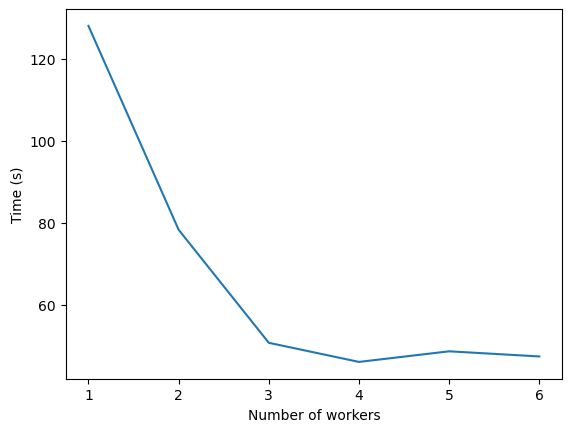

In [ ]:
import matplotlib.pyplot as plt
# performace plot
plt.plot(worker_times.keys(), worker_times.values())
plt.xlabel('Number of workers')
plt.ylabel('Time (s)')
plt.show()

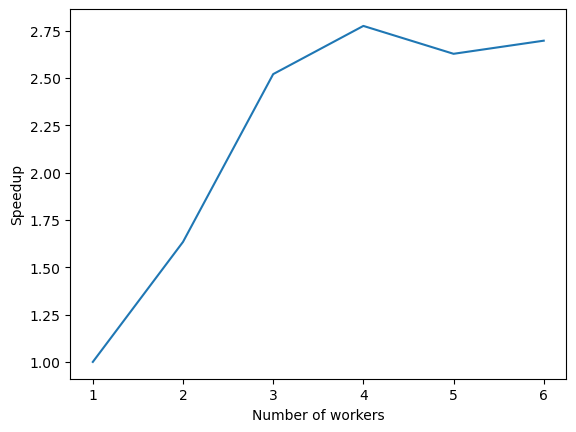

In [ ]:
# speedup plot
speedup = [worker_times[1]/t for t in worker_times.values()]
plt.plot(worker_times.keys(), speedup)
plt.xlabel('Number of workers')
plt.ylabel('Speedup')
plt.show()

### Análisis de rendimiento del proceso de paralelización del entrenamiento

Para realizar el análisis del rendimiento, cabe destacar que la ejecución ha tenido lugar en la máquina virtual proporcionada, donde se emplean un máximo 4 núcleos de CPU. Por tanto todos los experimentos han sido realizados en las mismas condiciones de ejecución. La gráficas anteriormente mostradas, muestra los resultados de rendimiento que supone este proceso de paralelización en función del número de workers asignados. La primera de ellas recoge los tiempos de ejecución en segundos, mientras que la segunda gráfica representa el speed-up, que es una medida de la mejora de rendimiento que se obtiene al útilizar un número determinado de nodos en comparación con un único nodo. Para la obtención de los resultados se ha obtenido la media de 3 ejecuciones para cada número de workers, 1, 2, 3, 4, 5 y 6.

Lo que se espera previo a la ejecucón de este experimento, es obtener una reducción en tiempos de computo a medida que aumenta el número de workers disponibles en el proceso de paralelización, y por tanto, que el speedup aumente. Ambas gráficas confirman la hipotesis planteada inicialmente. En la primera grafica, se observa una considerable reducción en los tiempos de ejecución donde respecto al empleo de un único nodo con el empleo del máximo de núcleos de CPU disponibles se produce un ahorro de casi más de la mitad del tiempo de entrenamiento. La reducción en tiempos observada no es lineal, llegando a encontrar una asintota a medida que nos acercamos a los 4 workers. El empleo de más workers que núcleos habilitados tampoco ha supuesto una mejoráa, incluso se ha observado un ligero aumento en los tiempos de computo. Estas mismas tendencias se pueden apreciar en la gráfica de speed-up, donde el pico máximo de mejora respecto al empleo de un único nodo se alcanza con 4 workers, realizando el entrenamiento 2.75 veces más rápido. Al igual que ocurre en la primera gráfica, el crecimineto no es lineal, es decir, no se duplica al duplicarse el número de recursos. Estabilizandose la curva al superar el número máximo de núcleos de CPU disponibles en la máquina virtual.

Los resultados anteriormente expuestos y recogidos en las gráficas, nos permite concluir que el proceso de paralelización del entrenamiento supone una gran ventaja reduciendo considerablemente el tiempo de ejecución. También, se puede deducir que cuanto mayor sea el número de datos que se requieren procesar, más beneficio se puede obtener de la paralelización. Además, no supone una ventaja el empleo de un número de workers superior al número máximo de núcleos de CPU disponibles.
